In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir('/kaggle/input'))

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['asl-signs']


In [2]:
import matplotlib.pyplot as plt

In [3]:
dataset_path = '/kaggle/input/asl-signs/train_landmark_files'
user_ids = os.listdir('/kaggle/input/asl-signs/train_landmark_files')

In [4]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [5]:
test_path = '/kaggle/input/asl-signs/train_landmark_files/36257'

In [6]:
test_filenames = os.listdir(test_path)

In [7]:
parquet_path = os.path.join(test_path, test_filenames[1])
print(parquet_path)

/kaggle/input/asl-signs/train_landmark_files/36257/1613088982.parquet


In [8]:
mytest0 = load_relevant_data_subset(parquet_path)
mytest0.shape

(6, 543, 2)

In [9]:
x_test, y_test = mytest0[0][:,0],mytest0[0][:,1]

In [10]:
type(mytest0)

numpy.ndarray

In [11]:
mytest0[0]

array([[0.4728077 , 0.5271512 ],
       [0.4659536 , 0.48752975],
       [0.467586  , 0.50070834],
       ...,
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]], dtype=float32)

### **Prepocessing**

In [31]:
parquet_path = os.path.join(test_path, test_filenames[0])
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
parquet_df = pd.read_parquet(parquet_path, columns=cols)
parquet_df.head()

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.536712,0.421679,-0.054983
1,0,0-face-1,face,1,0.532607,0.388884,-0.064112
2,0,0-face-2,face,2,0.535190,0.405216,-0.043147
3,0,0-face-3,face,3,0.515270,0.369050,-0.034260
4,0,0-face-4,face,4,0.530208,0.380113,-0.063684


In [13]:
# normalized_df=(df-df.mean())/df.std()

In [14]:
parquet_df_f = parquet_df[parquet_df.frame == 1]
parquet_df_c = parquet_df_f.copy()

In [64]:
len(parquet_df.frame.unique())

46

In [65]:
np.min(parquet_df_c.x)

-0.1281794160604477

In [66]:
# remove NaN value, replace by mean
parquet_df_c['x'] = parquet_df_f['x'].fillna(parquet_df_f['x'].mean())
parquet_df_c['y'] = parquet_df_f['y'].fillna(parquet_df_f['y'].mean())

In [67]:
np.sum(parquet_df_c.y.isna())

0

In [68]:
# normalize columns
normalized_df = parquet_df_c.copy()
normalized_df['x'] = (parquet_df_c['x']-parquet_df_c['x'].min())/(parquet_df_c['x'].max()-parquet_df_c['x'].min())
normalized_df['y'] = (parquet_df_c['y']-parquet_df_c['y'].min())/(parquet_df_c['y'].max()-parquet_df_c['y'].min())

In [69]:
np.max(normalized_df['x']), np.max(normalized_df['y'])

(1.0, 1.0)

In [70]:
normalized_df.head()

,frame,row_id,type,landmark_index,x,y,z
543,1,1-face-0,face,0,0.588677,0.064449,-0.054941
544,1,1-face-1,face,1,0.581115,0.047143,-0.064297
545,1,1-face-2,face,2,0.583609,0.055006,-0.043175
546,1,1-face-3,face,3,0.566529,0.037865,-0.034484
547,1,1-face-4,face,4,0.579109,0.043000,-0.063891


In [72]:
normalized_df.index

Index([ 543,  544,  545,  546,  547,  548,  549,  550,  551,  552,
       ...
       1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085],
      dtype='int64', length=543)

In [62]:
# lips idx
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# left hand, by taking account face from 0 to 468
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

REDUCED_LANDMARKS = np.sort(np.concatenate([LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0]))
print(REDUCED_LANDMARKS)

[  0  13  14  17  37  39  40  61  78  80  81  82  84  87  88  91  95 146
 178 181 185 191 267 269 270 291 308 310 311 312 314 317 318 321 324 375
 402 405 409 415 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 502 503 504 505 506 507 508 509 510 511 522
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542]


In [48]:
frame_df = parquet_df[parquet_df.frame == 0]
xx = frame_df[frame_df.type=='left_hand'].x
yy = frame_df[frame_df.type=='left_hand'].y

In [55]:
frame_df.head()

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.536712,0.421679,-0.054983
1,0,0-face-1,face,1,0.532607,0.388884,-0.064112
2,0,0-face-2,face,2,0.535190,0.405216,-0.043147
3,0,0-face-3,face,3,0.515270,0.369050,-0.034260
4,0,0-face-4,face,4,0.530208,0.380113,-0.063684


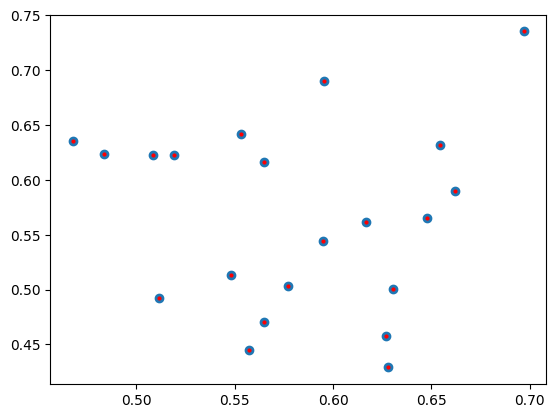

In [49]:
plt.scatter(xx,yy)
plt.scatter(xx[LEFT_HAND_IDXS0], yy[LEFT_HAND_IDXS0], s=4,c = 'r')

**Note** positions kept as wanted

In [ ]:
parquet_path = os.path.join(dataset_path, user_ids[0],test_filenames[10]) # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
parquet_df = pd.read_parquet(parquet_path, columns=cols)
# type distribution for 1st seuence
dd= dict(parquet_df.type.value_counts())

In [18]:
# function to replace NaN and normalize columns 
pq_path = os.path.join(dataset_path, user_ids[0],test_filenames[3]) # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
sqc_df = pd.read_parquet(pq_path, columns=cols)

In [82]:
def normalize_sequence(sequence_dataframe):
    '''
        function to normalize coordinates columns (x,y) per frame, also replace NaN values by column mean
        sequence_dataset is a pandas dataframe containing a sequence of an user
    '''



    frame_sqc_idx = sqc_df.frame.unique()
    normalized_df = pd.DataFrame()

    for frame in frame_sqc_idx:
        frame_df = sqc_df[sqc_df.frame == frame]
        frame_df1 = frame_df.copy()
        
        na_x = frame_df['x'].fillna(0.0)
        na_y = frame_df['y'].fillna(0.0)

        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        frame_df1.x, frame_df1.y = x_norm, y_norm
        normalized_df = pd.concat([normalized_df, frame_df1])
    
    return normalized_df

normalized_df=normalize_sequence(sqc_df)

In [28]:
len(sqc_df), len(normalized_df)

(10860, 10860)

In [14]:
len(parquet_df[parquet_df.frame == 0])

543

In [19]:
v = load_relevant_data_subset(pq_path)
print(v.shape)
u = v[0]
# frame 0, x values
print(u[:,0])

(20, 543, 2)
[0.49785304 0.49296054 0.49316776 0.47982183 0.4923693  0.49141657
 0.48911068 0.39541873 0.48771486 0.4870024  0.48351794 0.49809608
 0.49809906 0.49806887 0.498291   0.498963   0.49954534 0.50012165
 0.49872577 0.4930951  0.4804915  0.34566933 0.4325861  0.41972232
 0.40719122 0.39057052 0.44342962 0.41178247 0.42665544 0.39835703
 0.38983038 0.38087064 0.44992405 0.39075893 0.3431068  0.3665883
 0.42791194 0.4817936  0.4839827  0.46626258 0.45528576 0.47123274
 0.4606456  0.4376383  0.48203522 0.48004305 0.37273598 0.4514193
 0.4502945  0.4488746  0.39002255 0.47975475 0.40300012 0.38483137
 0.35808402 0.46108788 0.43977714 0.42735326 0.3620713  0.46038213
 0.471453   0.441658   0.444891   0.37799504 0.4499339  0.42830777
 0.4252444  0.41049552 0.36872092 0.4204503  0.36545792 0.35510725
 0.48279887 0.46884587 0.4579569  0.46376342 0.44331384 0.44998002
 0.44667643 0.46671978 0.4626028  0.47294343 0.48497272 0.48074484
 0.48347324 0.48363823 0.48413378 0.48498243 0.4625

In [64]:
def normalize_loaded_sequence(loaded_sqc):
    normalized_sqc = np.zeros((loaded_sqc.shape[0], len(REDUCED_LANDMARKS), 2))
    
    for frm_idx in range(loaded_sqc.shape[0]):
        frame_array = loaded_sqc[frm_idx]
        
        na_x = np.nan_to_num(frame_array[REDUCED_LANDMARKS,0], nan=0.0)
        na_y = np.nan_to_num(frame_array[REDUCED_LANDMARKS,1], nan=0.0)


        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        normalized_sqc[frm_idx,:,0],  normalized_sqc[frm_idx,:,1] = x_norm, y_norm
    
    return normalized_sqc

n_v = normalize_loaded_sequence(v)
print(n_v.shape)
print(np.max(n_v[0,:,0]), np.min(n_v[0,:,0]))

(20, 92, 2)
1.0 0.0


**Note** at this step I have a normalized tensor built after loading data

In [65]:
def get_data(sqc_path):
    data = load_relevant_data_subset(sqc_path)
    data = normalize_loaded_sequence(data)
    return data

In [89]:
pq_path = os.path.join(dataset_path, user_ids[0],test_filenames[0]) # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
sqc_df = pd.read_parquet(pq_path, columns=cols)

vv = get_data(pq_path)
print(vv.shape)

(46, 92, 2)


In [97]:
len(n_df.frame.unique())

46

In [93]:
n_df = normalize_sequence(sqc_df)
frame_df0 = n_df[n_df.frame == n_df.frame.unique()[0]]
frame_df1 = n_df[n_df.frame == n_df.frame.unique()[10]]

X0 = frame_df0.x
Y0= frame_df0.y

X1 = frame_df1.x
Y1= frame_df1.y

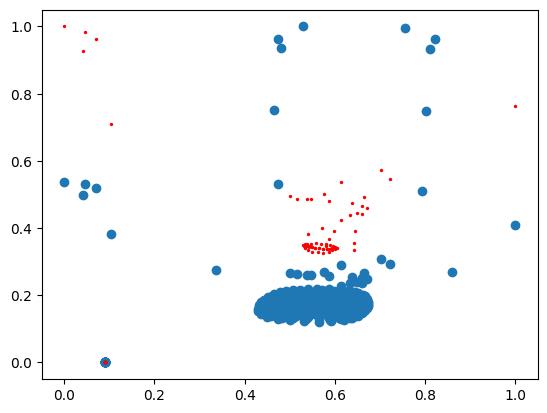

In [94]:
plt.figure()
plt.scatter(X0,Y0)
plt.scatter(vv[0,:,0],vv[0,:,1], s=2, c='r')
plt.show()

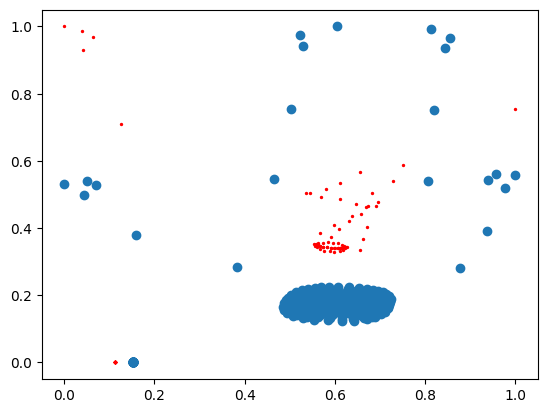

In [95]:
plt.figure()
plt.scatter(X1,Y1)
plt.scatter(vv[1,:,0],vv[1,:,1], s=2, c='r')
plt.show()

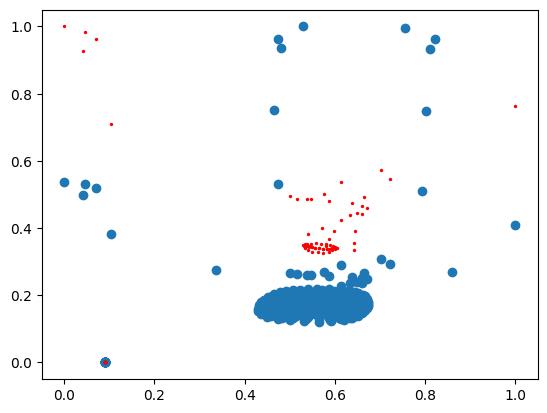

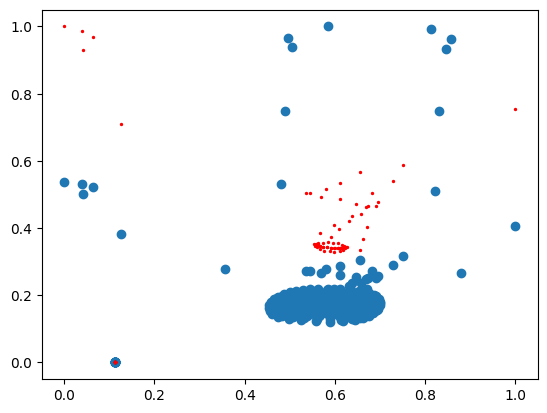

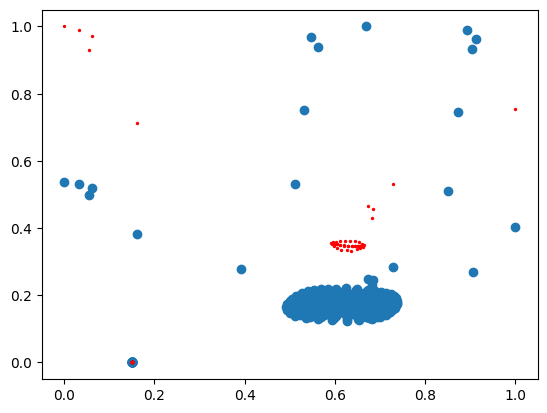

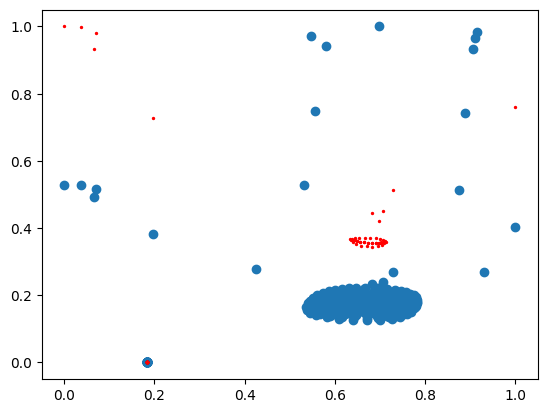

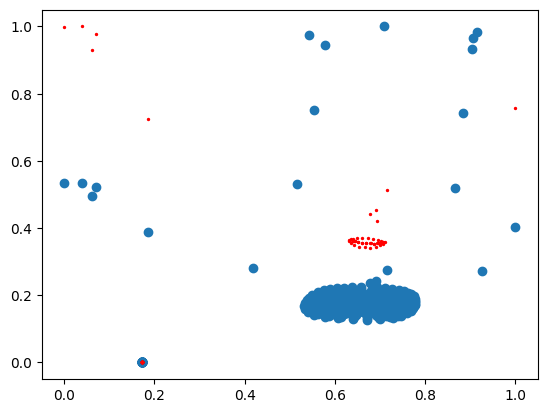

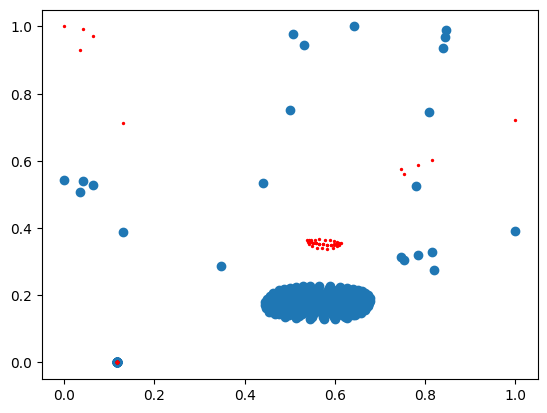

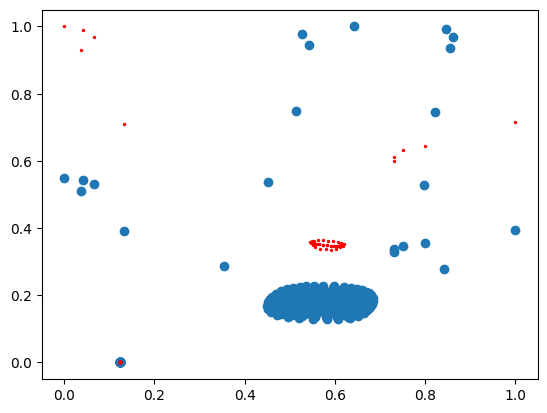

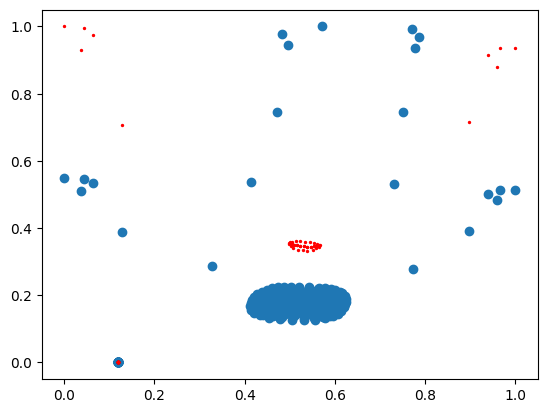

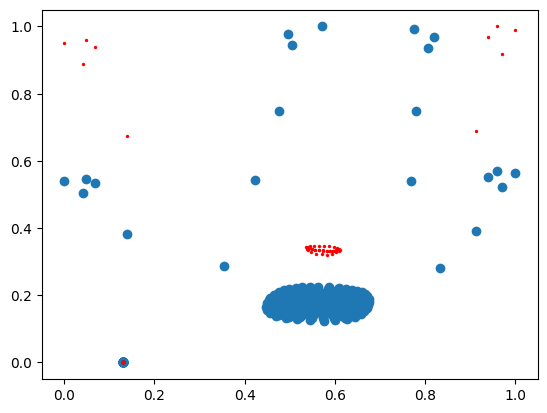

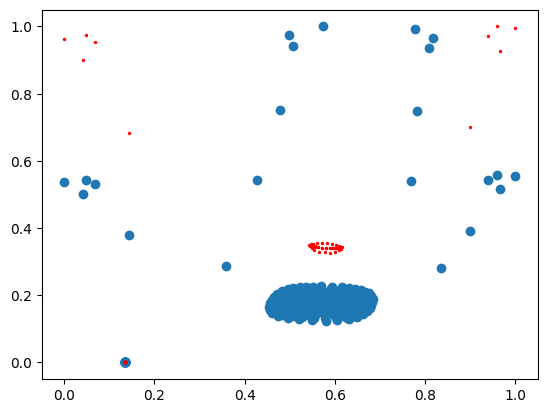

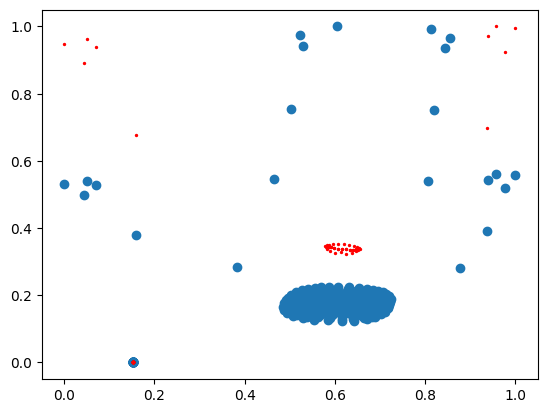

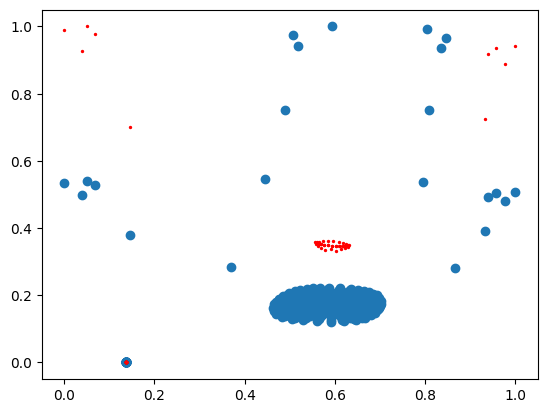

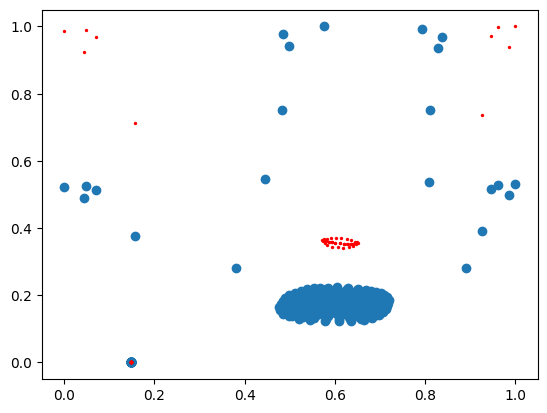

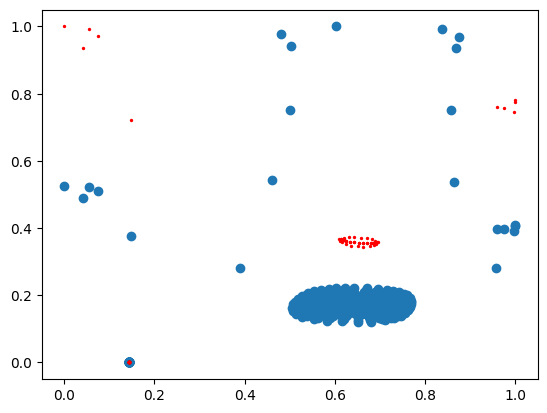

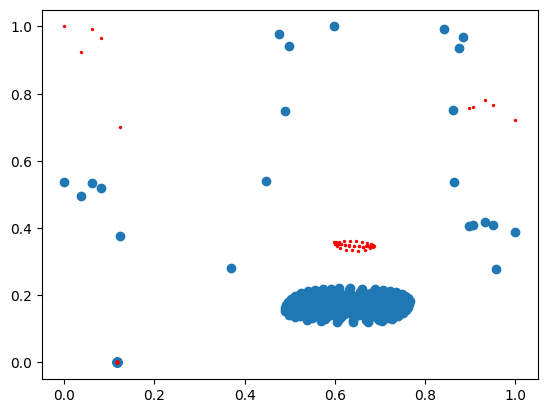

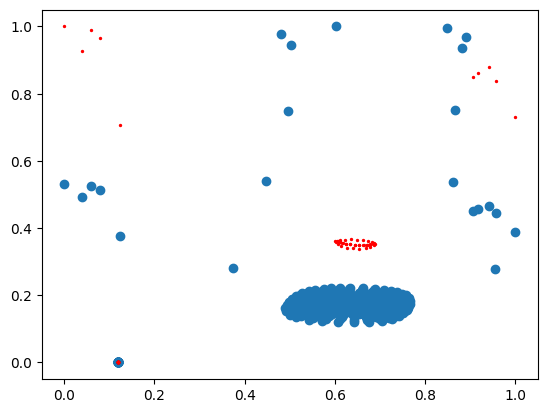

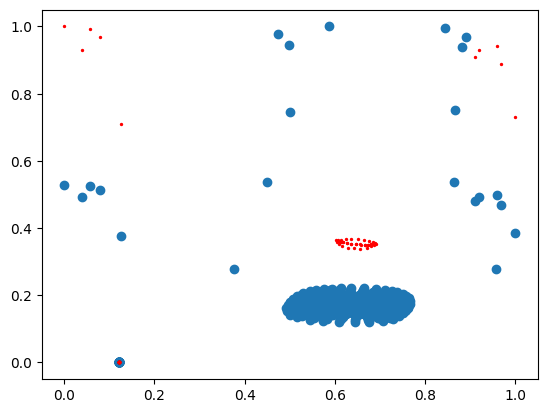

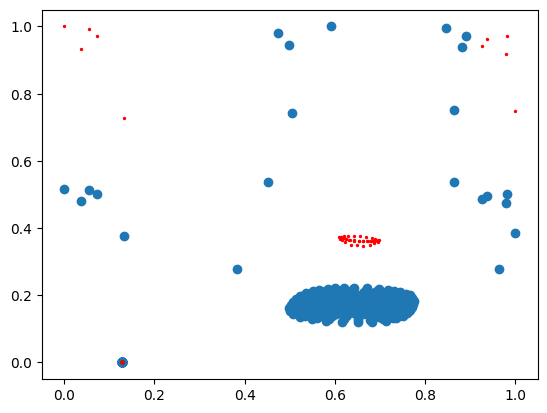

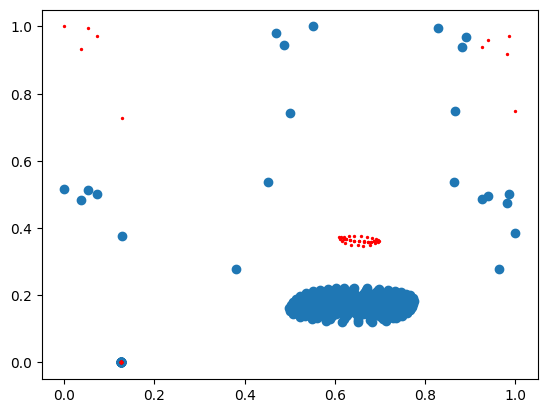

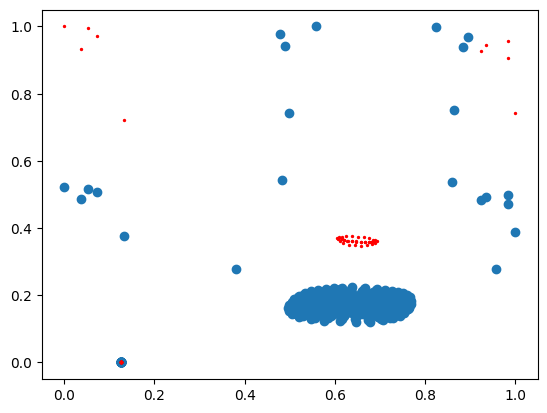

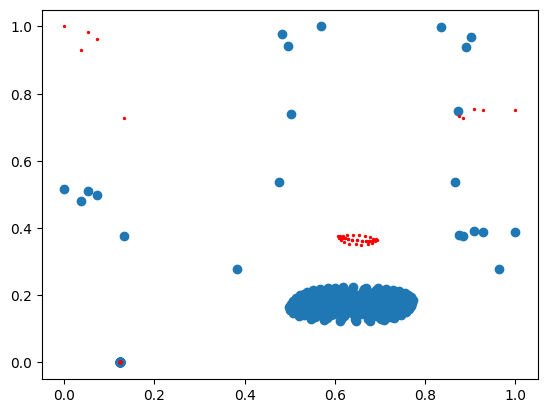

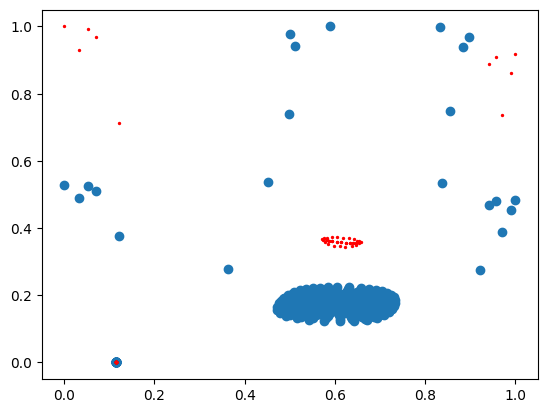

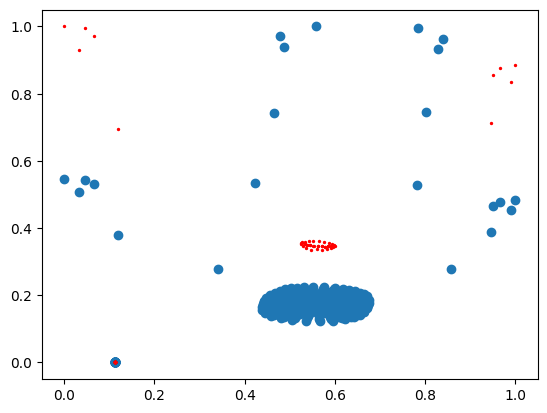

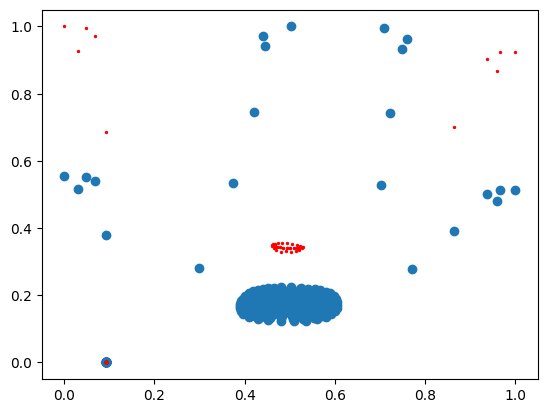

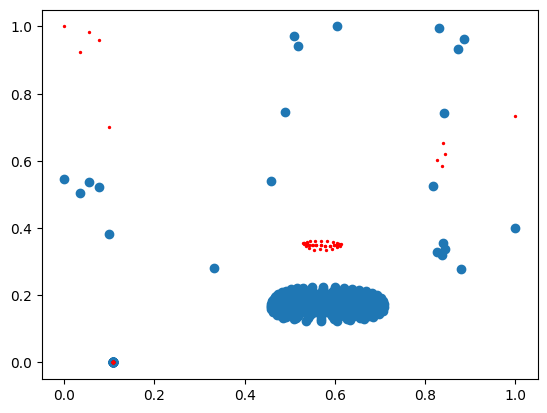

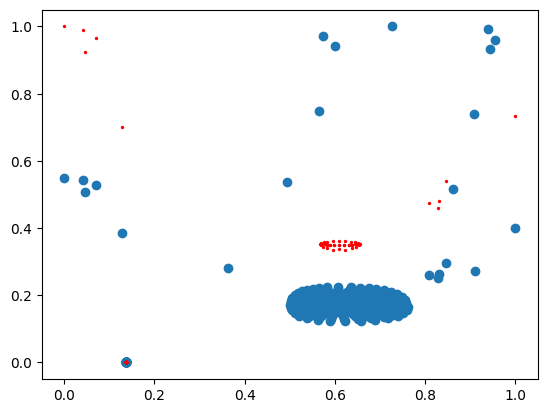

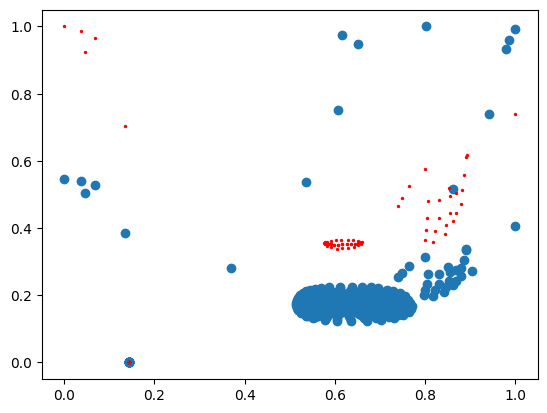

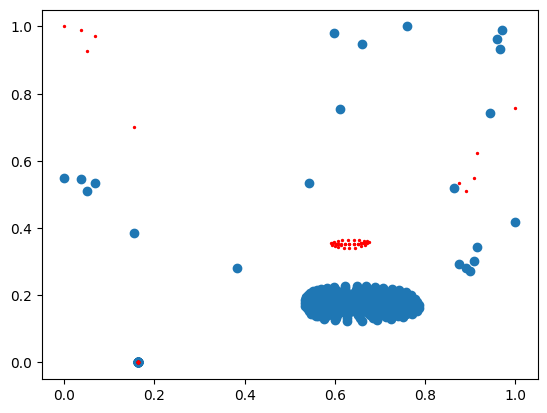

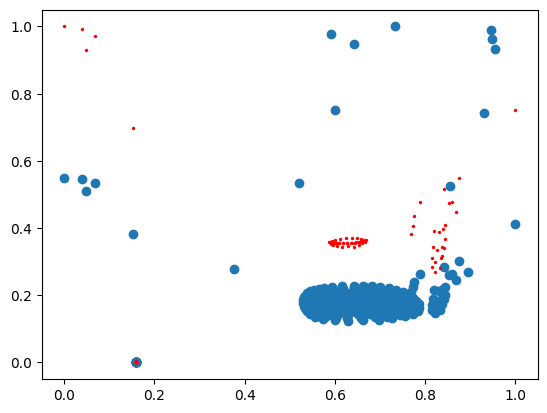

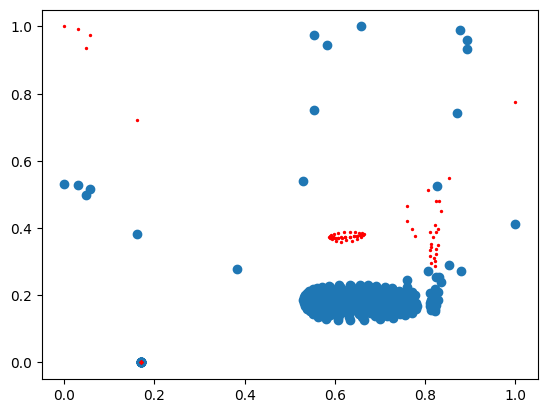

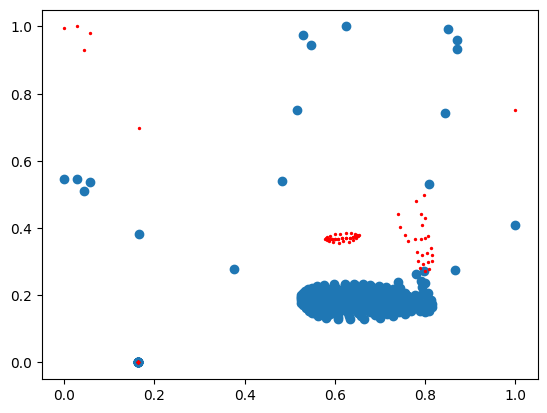

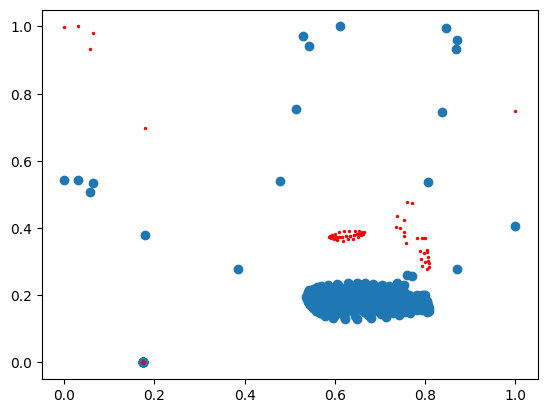

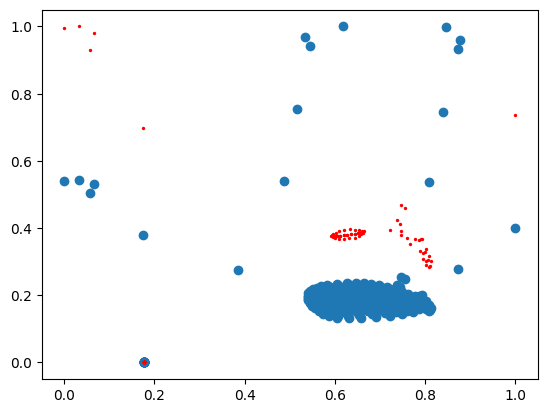

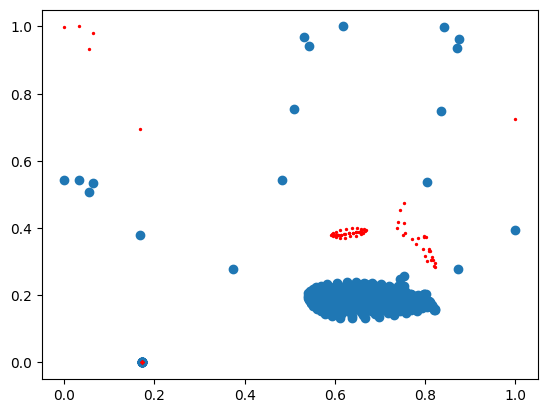

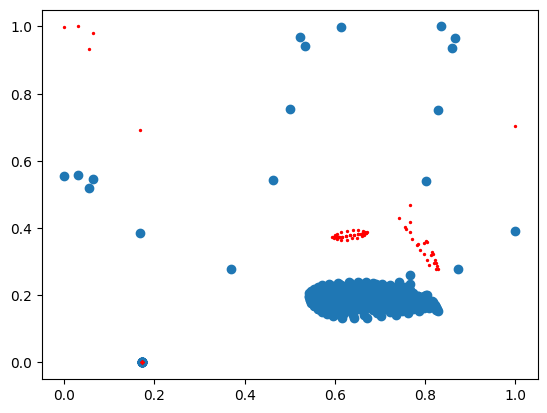

KeyboardInterrupt: 

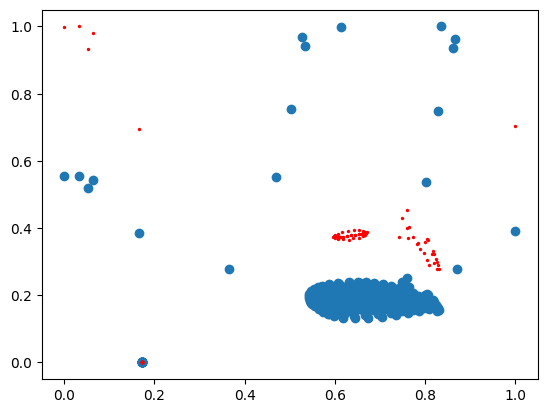

In [107]:
plt.figure()
for i in n_df.frame.unique():
    frame_df0 = n_df[n_df.frame == i]

    X0 = frame_df0.x
    Y0= frame_df0.y
    
    plt.scatter(X0,Y0)
    plt.scatter(vv[i,:,0],vv[i,:,1], s=2, c='r')
#     plt.show()
    plt.pause(0.1)

#### **Note** 
Normalization using min-max change position of point when using less (but most important) landmarks, is it normal as we used less points.
But movement keep the same

- RNN or LSTM can be a good simple approach for starting (it can be adapted for Time Series) 

In [96]:
1086/3

362.0

#### **TODO**
* thing about data augmentation
* try to use coatnet -> need to input data with same shape
* padding ?
    - issue with padding is that we have sequence with much more frames than other, maybe reduce thoses sequences and padding for small sequences
    - goal: have se

In [137]:
64*66*3

12672

In [119]:
3*64

192

In [117]:
vv[0].shape

(543, 2)

In [98]:
sqc_df.x.head()

0    0.501011
1    0.489817
2    0.491387
3    0.478273
4    0.489085
Name: x, dtype: float64

In [ ]:
parquet_df[parquetagg_df.frame ==5].type.value_counts()

In [ ]:
parquet_df.frame.value_counts().sum()

In [83]:
train_path = '/kaggle/input/asl-signs/train.csv'
train = pd.read_csv(train_path)

In [86]:
len(train)

94477

In [87]:
64*66

4224

In [84]:
train.columns

Index(['path', 'participant_id', 'sequence_id', 'sign'], dtype='object')

In [85]:
train.sign.unique()

array(['blow', 'wait', 'cloud', 'bird', 'owie', 'duck', 'minemy', 'lips',
       'flower', 'time', 'vacuum', 'apple', 'puzzle', 'mitten', 'there',
       'dry', 'shirt', 'owl', 'yellow', 'not', 'zipper', 'clean',
       'closet', 'quiet', 'have', 'brother', 'clown', 'cheek', 'cute',
       'store', 'shoe', 'wet', 'see', 'empty', 'fall', 'balloon',
       'frenchfries', 'finger', 'same', 'cry', 'hungry', 'orange', 'milk',
       'go', 'drawer', 'TV', 'another', 'giraffe', 'wake', 'bee', 'bad',
       'can', 'say', 'callonphone', 'finish', 'old', 'backyard', 'sick',
       'look', 'that', 'black', 'yourself', 'open', 'alligator', 'moon',
       'find', 'pizza', 'shhh', 'fast', 'jacket', 'scissors', 'now',
       'man', 'sticky', 'jump', 'sleep', 'sun', 'first', 'grass', 'uncle',
       'fish', 'cowboy', 'snow', 'dryer', 'green', 'bug', 'nap', 'feet',
       'yucky', 'morning', 'sad', 'face', 'penny', 'gift', 'night',
       'hair', 'who', 'think', 'brown', 'mad', 'bed', 'drink', 'stay',


In [ ]:
len(os.listdir('/kaggle/input/asl-signs/train_landmark_files'))

In [ ]:
train.participant_id.unique(), len(train.participant_id.unique())

In [ ]:
train[train.participant_id == 16069]

In [ ]:
d=dict(train.sign.value_counts(dropna=True))
print(train.sign.value_counts(dropna=True).mean())
print(train.sign.value_counts(dropna=True).std())
print(train.sign.value_counts(dropna=True).max())
print(train.sign.value_counts(dropna=True).min())

# word distribution is not too expended
# any words have close occurences

#### **Some notes:**
* each parquet contains markers position [x y z] and type (face, left_hand, pose, right_hand) for different frame
* train dataset is composed of image path, participant id (folder name of parquet file) sequence id (filename) and word said
* one sequence = numerous frames = 1 word
* every frame has data for each type, but it is possible that one type has no value in a frame, it is setted to NaN

**Goal**: using hand position, be able to understand word said in the sequence
* classification between 250 words using positions of body parts in video

In [ ]:
import json
 
# Opening JSON file
f = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)
print(len(data), data)

In [ ]:
train_words = train.sign.unique()
print(len(train_words))
# same length as sign to prediction index json

#### **Analysis Ideas**

* class embalencement (count words for each element in train dataset)
* size analysis (lenght of sequence, linked to words ?)
* position ranges (x y z)
* number of sequence per participant 
* train dataset will be splitted for train test val

In [ ]:
landmark_folders = '/kaggle/input/asl-signs/train_landmark_files'

squences_per_user = {}

user_ids= os.listdir(landmark_folders)

for user_foler in user_ids:
    squences_per_user[user_foler] = len(os.listdir(os.path.join(landmark_folders,user_foler)))
    print(len(os.listdir(os.path.join(landmark_folders,user_foler))))

In [ ]:
print(f'max number of sequence: {np.max(list(squences_per_user.values()))}\nmin number of sequence: {np.min(list(squences_per_user.values()))}\nmean of number of sequence per user: {int(np.mean(list(squences_per_user.values())))}\nstandard deviation: {int(np.std(list(squences_per_user.values())))}')

#### **Type analysis**

In [ ]:
my_df = pd.DataFrame(index=user_ids,columns=['face', 'pose','l_hand', 'r_hand'])

my_df.reset_index(inplace=True)
display(my_df)
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
# types_dic = {'face': 0, 'pose': 0, 'left_hand': 0, 'right_hand': 0}
for n,user in enumerate(user_ids):
    len_seq = 0
    user_dic = {'face': 0, 'pose': 0, 'left_hand': 0, 'right_hand': 0}
    sequence_files = os.listdir(os.path.join(dataset_path,user))
    for idx,sequence in enumerate(sequence_files):
        parquet_path = os.path.join(dataset_path, user, sequence)
        parquet_df = pd.read_parquet(parquet_path, columns=cols)
        len_seq+=len(parquet_df)
        
        sequence_dic = dict(parquet_df.type.value_counts())
        
        for key in user_dic.keys():
            user_dic[key]+=sequence_dic[key]
        
        
    print(user_dic, len_seq)
    my_df.iloc[n, 1:]  = [el/len_seq for el in list(user_dic.values())]

In [ ]:
my_df.columns

In [ ]:
my_df.to_csv('/kaggle/working/types_distribution.csv', columns=my_df.columns, header=True, index=False)

In [ ]:
pd.read_csv('/kaggle/working/types_distribution.csv')

In [ ]:
a=2699424
b=(60158592+4241952+2699424+2699424)

a/b

In [ ]:
c = 1318779
d = 29389932+2072367+1318779+1318779
c/d

In [ ]:
my_df.iloc[0, 1:]  = list(user_dic.values())
my_df.head()

In [ ]:
len(parquet_df)

In [ ]:
u=pd.DataFrame(index=[1,2],columns=['a', 'b'])
u.head()
u
u.head()

In [ ]:
parquet_path = os.path.join(dataset_path, user_ids[0],test_filenames[1]) # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
parquet_df = pd.read_parquet(parquet_path, columns=cols)
# type distribution for 1st seuence
dd= dict(parquet_df.type.value_counts())

In [ ]:
# word signed in previsous sequence 
train.loc[train.path == parquet_path[24:]].sign

In [ ]:
parquet_path[24:]

In [ ]:
types_dic = {'face': 0, 'pose': 0, 'left_hand': 0, 'right_hand': 0}
for key in types_dic.keys():
     print(dd[key])

In [ ]:
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
sequence_files = os.listdir(os.path.join(dataset_path,user_ids[0]))
parquet_path = os.path.join(dataset_path, user_ids[0], sequence_files[0])
parquet_df = pd.read_parquet(parquet_path, columns=cols)

In [ ]:
parquet_df.row_id.unique()

In [ ]:
parquet_df.groupby(['type']).head()

In [ ]:
user_enum = enumerate(user_ids)

In [ ]:
_,user = next(user_enum)
sequence_files = os.listdir(os.path.join(dataset_path,user))
parquet_path = os.path.join(dataset_path, user, sequence_files[0])
parquet_df = pd.read_parquet(parquet_path, columns=cols)

type_mean = parquet_df.groupby(['type'])[['x', 'y', 'z']].mean().reset_index(drop=False)
type_mean.head()

In [ ]:
next(enumerate(user_ids))

### **21/05 Test Landmark Index**

In [57]:
parquet_path = os.path.join(dataset_path, user_ids[0],test_filenames[10]) # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
parquet_df = pd.read_parquet(parquet_path, columns=cols)
# type distribution for 1st seuence
dd= dict(parquet_df.type.value_counts())

In [52]:
parquet_path

'/kaggle/input/asl-signs/train_landmark_files/36257/1613088982.parquet'

In [53]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

In [66]:
df= parquet_df
df.type.unique()

array(['face', 'left_hand', 'pose', 'right_hand'], dtype=object)

In [58]:
face_df = parquet_df[parquet_df.type == 'face']
f_id = face_df.frame[0]
face_df_f0 = face_df[face_df.frame == f_id]

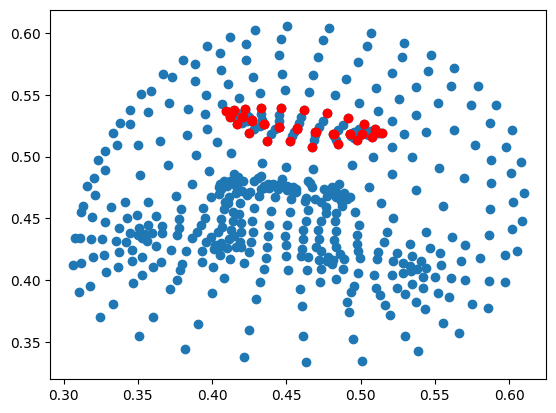

In [59]:
plt.scatter(face_df_f0.x, face_df_f0.y)
plt.scatter(face_df_f0.x[LIPS_IDXS0], face_df_f0.y[LIPS_IDXS0], c='r')


In [34]:
face_df_f0.x[LIPS_IDXS0]

61     0.500093
185    0.501735
40     0.505564
39     0.512047
37     0.523359
0      0.536712
267    0.548980
269    0.563962
270    0.573741
409    0.580429
291    0.584133
146    0.504653
91     0.510771
181    0.520170
84     0.532024
17     0.545322
314    0.557952
405    0.568556
321    0.576165
375    0.580979
78     0.504075
191    0.510139
80     0.515009
81     0.521754
82     0.530374
13     0.540343
312    0.550075
311    0.558963
310    0.566719
415    0.572698
95     0.509708
88     0.514745
178    0.521571
87     0.530378
14     0.540652
317    0.550548
402    0.559455
318    0.567018
324    0.572905
308    0.579548
Name: x, dtype: float64

In [63]:
face_df.landmark_index.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [64]:
pose_df = parquet_df[parquet_df.type == 'pose']
pose_df.landmark_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int16)

In [67]:
lh_df = parquet_df[parquet_df.type == 'left_hand']
lh_df.landmark_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int16)

In [68]:
rh_df = parquet_df[parquet_df.type == 'right_hand']
rh_df.landmark_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int16)